In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt # Visualization
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

test.csv
train.csv



In [30]:
# Load Data
train_raw = pd.read_csv("../input/train.csv")
test_raw = pd.read_csv("../input/test.csv")
print("Data Loaded")

Data Loaded


In [31]:
def get_features(raw_data):
    cols = []
    # Get data of each row from pixel0 to pixel783 
    for px in range(784):
        cols.append("pixel"+str(px))   
    return raw_data.as_matrix(cols)/255

def cross_validated(X, n_samples):
    kf = KFold(n_samples, shuffle = True)
    result = [group for group in kf.split(X)]
    return result        

In [32]:
# Deep Implementation 
# Initialize Parameters 
def init_dnn_parameters(n, activations, epsilons, filter=None):
    L = len(n)
    params = {}
    for l in range(1,L):
        W = np.random.randn(n[l],n[l-1]) * epsilons[l] 
        # Experiment, multiply filter in case of input layer weights 
        if filter1 is not None and l == 1:
            W = np.dot(W, filter) 
        b = np.zeros((n[l],1))
        params["W"+str(l)] = W
        #print(" initizlizing W"+str(l))
        params["b"+str(l)] = b                        
        params["act"+str(l)] = activations[l]
    params["n"] = n
    return params

# Activation Functions 
def gdnn(X, activation_function):
    leak_factor = 1/10000
    if activation_function == 'tanh':
        return np.tanh(X)
    if activation_function == 'lReLU':
        return ((X > 0) * X) + ((X <= 0)* X * leak_factor)
    else: 
        return 1 / (1 +np.exp(-X))

def gdnn_prime(X, activation_function):
    leak_factor = 1/10000
    if activation_function == 'tanh':
        return 1-np.power(X,2)
    if activation_function == 'lReLU':
        return ((X > 0) * 1) + ((X <= 0)* leak_factor)
    else: 
        return (1 / (1 +np.exp(-X)))*(1-(1 / (1 +np.exp(-X))))

# Cost 
def get_dnn_cost(Y_hat, Y):
    #print(Y.shape)
    m = Y.shape[1]
    logprobs = np.multiply(np.log(Y_hat),Y) + np.multiply(np.log(1-Y_hat),1-Y)
    cost = - np.sum(logprobs) /m
    return cost
    
# Forward Propagation 
def forward_dnn_propagation(X, params):
    # Get Network Parameters 
    n = params["n"]
    L = len(n)
    
    A_prev = X
    cache = {}
    cache["A"+str(0)] = X
    for l in range(1,L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        Z = np.dot(W,A_prev)+b
        A = gdnn(Z,params['act'+str(l)])
        cache["Z"+str(l)] = Z
        cache["A"+str(l)] = A
        
        A_prev = A
    return A, cache 

# Backward Propagation
def back_dnn_propagation(X, Y, params, cache, alpha = 0.01, _lambda=0, keep_prob=1):
    n = params["n"]
    L = len(n) -1
    
    m = X.shape[1]
    W_limit = 5
    A = cache["A"+str(L)]
    A1 = cache["A"+str(L-1)]
    #print("back_dnn_propagation: A(L) shape"+str(A.shape))
    #print("back_dnn_propagation: A1(L) shape"+str(A1.shape))
    grads = {}
    
    # Outer Layer 
    dZ = A - Y#gdnn_prime(A - Y, params["act"+str(L)])
    #print("back_dnn_propagation: dZ(L) shape"+str(dZ.shape))
    dW = 1/m * np.dot(dZ, A1.T)
    #print("back_dnn_propagation: dW(L) shape"+str(dW.shape))
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    grads["dZ"+str(L)] = dZ
    grads["dW"+str(L)] = dW + _lambda/m * params["W"+str(L)]
    grads["db"+str(L)] = db
    
    # Update Outer Layer
    params["W"+str(L)] -= alpha * dW
    #params["W"+str(L)] = np.clip(params["W"+str(L)],-W_limit,W_limit)
    params["b"+str(L)] -= alpha * db
    for l in reversed(range(1,L)):
        #dZ2 = A2 - Y
        #dW2 = 1/m * np.dot(dZ2, A1.T)
        #db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
        #dZ1 = np.dot(W2.T, dZ2)*g_prime(A1)
        #dW1 = 1/m * np.dot(dZ1, X.T)
        #db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
        
        dZ2 = dZ
        W2 = params["W"+str(l+1)]
        b = params["b"+str(l)]
        A2 = cache["A"+str(l)]
        A1 = cache["A"+str(l-1)]
        d = np.random.randn(A1.shape[0],A1.shape[1]) > keep_prob
        A1 = A1 * d/keep_prob
        dZ = np.dot(W2.T, dZ2)*gdnn_prime(A2, params["act"+str(l)])

        dW = 1/m * np.dot(dZ, A1.T) + _lambda/m * params["W"+str(l)]
        
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        grads["dZ"+str(l)] = dZ
        grads["dW"+str(l)] = dW
        grads["db"+str(l)] = db
        params["W"+str(l)] -= alpha *dW
        #params["W"+str(l)] = np.clip(params["W"+str(l)],-W_limit,W_limit)
        params["b"+str(l)] -= alpha *db
    
    return grads, params    

def batch_back_propagation(X, Y, params, cache, alpha = 0.01, _lambda=0, keep_prob=1,batch_size=128):
    # slice input and output data into smaller chunks 
    m = X.shape[1]
    include_probability = keep_prob
    idx_from = 0
    idx_to = min(batch_size, m)
    X_train = X[:,idx_from:idx_to]
    y_train = Y[:,idx_from:idx_to]
    while idx_to < m:
        #print("Epoch from {} to {}".format(idx_from, idx_to))
        if np.random.random() < include_probability:
            A, cache = forward_dnn_propagation(X_train, params)
            grads, params= back_dnn_propagation(X_train, y_train, params, cache, alpha ,_lambda, keep_prob)    
        idx_from += batch_size
        idx_from = min(m, idx_from)
        idx_to += batch_size
        idx_to = min(m, idx_to)
        if idx_from < idx_to:
            X_train = X[:,idx_from:idx_to]
            y_train = Y[:,idx_from:idx_to]
    return grads, params

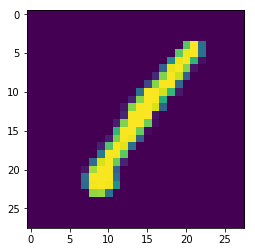

In [33]:
X2 = get_features(train_raw)
plt.imshow(np.reshape(X2[0,:],(int(np.sqrt(X2.shape[1])),int(np.sqrt(X2.shape[1])))))

According to my question at [Cross Validated](https://stats.stackexchange.com/questions/328817/vectorization-of-a-convolution-layer)  I need to build a transformation matrix $\mathcal{M}_k$ that would:

1. translate a group of pixels to the beginning of the image
1. crop the rest of the image 

for the sake of testing, let us define $\mathcal{M}_k \in \mathbb{R}^{25 \times n}$ to simulate a $5 \times 5$ patch 

In [34]:
sx = 9
sy = 9
cx = 0
cy = 0
orig_x_size = int(np.sqrt(X2.shape[1]))
orig_y_size = orig_x_size
M = np.zeros((X2.shape[1], (orig_x_size-sx)*(orig_y_size-sy)*sx*sy))
p_vec = 0
for cx in range(orig_x_size-sx):
    for cy in range(orig_y_size-sy):
        #
        #
        for px in range(sx):
            for py in range(sy):
                M[cx + px + (py+cy) * orig_x_size, p_vec] = 1
                p_vec += 1
        print("Processing: x:{}/{}, y:{}/{}".format(cx,orig_x_size-sx,cy,orig_y_size-sy))
P = np.dot(X2,M)       
#        P = np.concatenate((P, P_temp), axis = 1)
print(P.shape)

Processing: x:0/19, y:0/19
Processing: x:0/19, y:1/19
Processing: x:0/19, y:2/19
Processing: x:0/19, y:3/19
Processing: x:0/19, y:4/19
Processing: x:0/19, y:5/19
Processing: x:0/19, y:6/19
Processing: x:0/19, y:7/19
Processing: x:0/19, y:8/19
Processing: x:0/19, y:9/19
Processing: x:0/19, y:10/19
Processing: x:0/19, y:11/19
Processing: x:0/19, y:12/19
Processing: x:0/19, y:13/19
Processing: x:0/19, y:14/19
Processing: x:0/19, y:15/19
Processing: x:0/19, y:16/19
Processing: x:0/19, y:17/19
Processing: x:0/19, y:18/19
Processing: x:1/19, y:0/19
Processing: x:1/19, y:1/19
Processing: x:1/19, y:2/19
Processing: x:1/19, y:3/19
Processing: x:1/19, y:4/19
Processing: x:1/19, y:5/19
Processing: x:1/19, y:6/19
Processing: x:1/19, y:7/19
Processing: x:1/19, y:8/19
Processing: x:1/19, y:9/19
Processing: x:1/19, y:10/19
Processing: x:1/19, y:11/19
Processing: x:1/19, y:12/19
Processing: x:1/19, y:13/19
Processing: x:1/19, y:14/19
Processing: x:1/19, y:15/19
Processing: x:1/19, y:16/19
Processing: 

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4
11 4
12 4
13 4
14 4
15 4
16 4
17 4
18 4
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
11 5
12 5
13 5
14 5
15 5
16 5
17 5
18 5
0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
11 6
12 6
13 6
14 6
15 6
16 6
17 6
18 6
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8 7
9 7
10 7
11 7
12 7
13 7
14 7
15 7
16 7
17 7
18 7
0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
8 8
9 8
10 8
11 8
12 8
13 8
14 8
15 8
16 8
17 8
18 8
0 9
1 9
2 9
3 9
4 9
5 9
6 9
7 9
8 9
9 9
10 9
11 9
12 9
13 9
14 9
15 9
16 9
17 9
18 9
0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 10
13 10
14 10
15 10
16 10
17 10
18 10
0 11
1 11
2 11
3 11
4 11
5 11
6 11
7 11
8 11
9

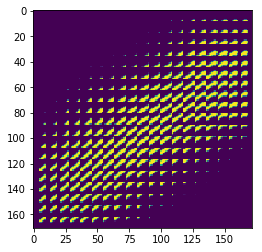

In [41]:
m_p, n_p = P.shape
one_side = int(np.sqrt(n_p))
slider = 0
block_size = sx * sy
show_case = np.reshape(P[0,slider:slider+block_size],(sx, sy))

line = np.zeros((sx,1))
for iy in range(0, (orig_y_size-sy)):
    print(ix, iy)
    #plt.imshow(np.reshape(P[0,slider:slider+block_size],(5, 5)))
    line = np.concatenate((line, np.reshape(P[0,slider:slider+block_size],(sx, sy))), axis = 1)        
    slider += block_size
show_case = line 

for iy in range(1, (orig_y_size-sy)):
    line = np.zeros((sx,1))
    for ix in range(0, (orig_x_size-sx)):
        print(ix, iy)
        #plt.imshow(np.reshape(P[0,slider:slider+block_size],(5, 5)))
        line = np.concatenate((line, np.reshape(P[0,slider:slider+block_size],(sx, sy))), axis = 1)        
        slider += block_size
    show_case = np.concatenate((show_case, line), axis = 0 )
plt.imshow(show_case)
plt.show()

In [36]:
print(np.sqrt(13225)/5)

23.0
